## Bullish on Broadway:  Can the model predict a hit or flop?

#### Import Programs

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

#### Load Data from previous EDA

In [65]:
data = pd.read_csv('Model_Data.csv')

In [66]:
new = pd.read_csv('NewShows.csv')

In [67]:
data.shape

(469, 31)

#### Eliminate revenue, attendance and ticket price , closing information, number of performances (everything that would not be known when a show opens!)

In [68]:
data = data.drop(['Show','Gross', 'Potential', 'Attendance', 'Capacity',
       'Weeks', 'Performances', 'AvgTicket', 'TopTicket', 'ZScore', 'G/P',
       'A/C', 'Theatre', 'CloseYear', 'CloseMonth', 'Npreform'], axis =1 )

In [69]:
data = data.set_index('ID')

In [70]:
new = new.drop(['CloseYear', 'CloseMonth', 'Npreform'], axis =1)

In [71]:
new = new.set_index('ID')

#### Numerical Features Model

In [72]:
numerical_features = list(data._get_numeric_data().drop(['Category'], axis=1).columns)

In [73]:
for feature in numerical_features:
    data[feature] = data[feature].fillna(-999)

In [74]:
numerical_features_test = list(new._get_numeric_data().columns)

In [75]:
for feature in numerical_features_test:
    new[feature] = new[feature].fillna(-999)

#### Categorical Features

In [76]:
categorical_columns = list(data.select_dtypes(include=['object']).columns)

In [77]:
data.columns

Index(['Category', 'O_R', 'M_P', 'Genre', 'OpenMonth', 'OpenYear', 'Coder',
       'Cast_Size', 'Theatre.1', 'Capacity.1', 'Street', 'ProdCredits',
       'Special', 'Organizer'],
      dtype='object')

In [78]:
for feature in categorical_columns:
    data[feature] = data[feature].fillna('None')
    new[feature] = new[feature].fillna('None')

In [79]:
for col in categorical_columns:
    data_values = sorted(list(data[col]))
    test_values = sorted(list(new[col]))
    categories = set(data_values + test_values)
    data[col] = pd.Categorical(data[col], categories = categories)
    new[col] = pd.Categorical(new[col], categories = categories)

In [80]:
data_dummies = pd.get_dummies(data[categorical_columns])

In [81]:
new_dummies = pd.get_dummies(new[categorical_columns])

In [82]:
df = pd.concat((data_dummies, data[numerical_features]), axis=1)

In [83]:
df_new = pd.concat((new_dummies, new[numerical_features]), axis =1 )

#### Correlation Matrix

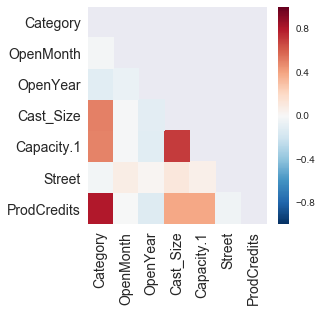

In [84]:
mean_corr = data.corr()

fig, ax = plt.subplots(figsize=(4,4))
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()

#### Create target vector (category) and predictor matrix

In [85]:
y = data.Category.copy()
X = df.copy()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 444448)

In [102]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
df_new_ss = ss.transform(df_new)
Xs = ss.transform(X)

#### Baseline Accuracy

In [88]:
baseline= 1 - np.mean(y)
print(baseline)

0.7121535181236673


### Ensemble Model

In [89]:
clf = DecisionTreeClassifier(max_depth=3)
bag_clf = BaggingClassifier(clf)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_bag))

0.940677966102


In [90]:
scores_bag = cross_val_score(bag_clf, X_train, y_train, cv=5)
print(scores_bag)
print(np.mean(scores_bag))

[ 0.98591549  0.92957746  0.9         0.95714286  0.88405797]
0.931338757181


In [91]:
predicted_bag = bag_clf.predict(X_test)

In [92]:
conmat = np.array(confusion_matrix(y_test, predicted_bag))
confusion = pd.DataFrame(conmat, index=['Is_Flop', 'Is_Hit'],
                        columns = ['Predicted_Flop', 'Predicted_Hit'])
confusion

,Predicted_Flop,Predicted_Hit
Is_Flop,86,6
Is_Hit,1,25


##### Gradient Boost Model

In [93]:
gbc = GradientBoostingClassifier()
gbc_params = {
    'n_estimators' : [75, 100, 50],
    'max_depth' : range(2,5),
    'max_features' : ['auto', 'log2', None]
}
gbc_model = GridSearchCV(gbc, param_grid= gbc_params)
gbc_model.fit(X_train, y_train)
print('Best Score: ', gbc_model.best_score_)
print('Best Params: ', gbc_model.best_params_)
print('Test Score: ', gbc_model.score(X_test, y_test))

Best Score:  0.940170940171
Best Params:  {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 50}
Test Score:  0.940677966102


In [130]:
scores_gbc = cross_val_score(gbc_model, X_train, y_train, cv=3)
print(scores_gbc)
print(np.mean(scores_gbc))

[ 0.93220339  0.95726496  0.93103448]
0.940167609951


In [116]:
predicted = gbc_model.predict(X_test)

In [117]:
conmat = np.array(confusion_matrix(y_test, predicted))
confusion = pd.DataFrame(conmat, index=['Is_Flop', 'Is_Hit'],
                        columns = ['Predicted_Flop', 'Predicted_Hit'])
confusion

,Predicted_Flop,Predicted_Hit
Is_Flop,86,6
Is_Hit,1,25


#### Feature Importance

In [96]:
all_data = pd.concat([df, data['Category']], axis=1)

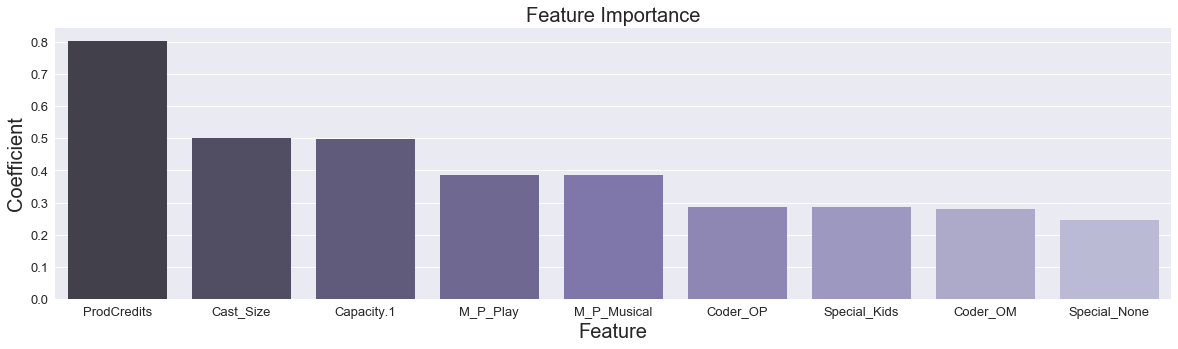

In [126]:
correlation = (all_data.corr()['Category'].apply(lambda x: abs(x)).sort_values(ascending=False).head(10))

corr_df = pd.DataFrame()
corr_df['Correlations'] = correlation
corr_df['Feature'] =correlation.index
corr_df.drop(['Category'], inplace= True)

plt.figure(figsize=(20, 5))
sns.barplot('Feature', 'Correlations', data= corr_df, palette='Purples_d')
plt.title('Feature Importance', size= 20)
plt.xlabel('Feature', size= 20)
plt.ylabel('Coefficient', size= 20)
plt.tick_params(labelsize=13)
plt.show()

#### New Shows

#### Upcoming 2018 Shows- which one's will be a success?

In [98]:
predicted_new = gbc_model.predict(df_new_ss)

In [99]:
new['Predict'] = predicted_new

In [100]:
new = new[['Show', 'Predict']]

In [101]:
new

,Show,Predict
ID,,
474,Angels in America: Millennium Approaches,0
475,Carousel,1
476,Children of a Lesser God,0
477,Escape to Margaritaville,0
478,Farinelli and the King,0
479,Frozen,1
480,Gettin' The Band Back Together,0
481,Harry Potter and the Cursed Child,1
482,John Lithgow: Stories by Heart,0
